This notebook has been migrated based on the author's TF v1 [[code link]](https://github.com/ratschlab/dpsom/tree/master/som_vae).

So far, it is only available for image samples such as MNIST in fashion MNIST.

Some part of the SOM-VAE is implemented for sequence or time-series datasets, but the whole is before migration from TF v1.

### Requirements

* tensorflow-gpu $\ge$ 2.6

# Library

In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import metrics

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import functools
from tqdm import tqdm
from collections import Counter

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

# Data loading

If you want to test with fashion MNIST, remark the line 1 and remove the hash the line 2

(3000, 30)
(60000, 1)


Text(0.5, 1.0, 'observations')

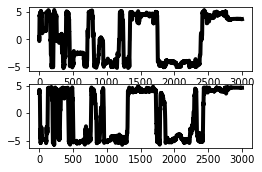

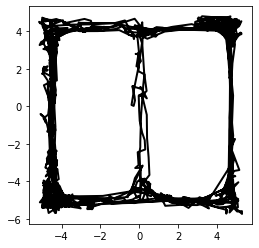

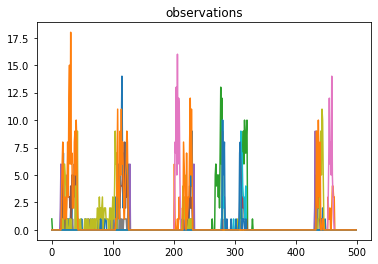

In [2]:
Time = 3000
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_3000.mat")
y_data = datax["spike30_sim_3000"] 
traj = scipy.io.loadmat("trj30_sim_3000.mat")
traj = traj["trj30_sim_3000"]
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')
# mnist = tf.keras.datasets.fashion_mnist.load_data() 
print(y_data.shape)
data_total = np.reshape(mnist[0][0], [-1,28*28])
maxx = np.reshape(np.amax(data_total, axis = -1), [-1,1])
print(maxx.shape)
data_total = np.reshape(data_total/maxx, [-1,28,28,1])
labels_total = mnist[0][1]

data_train, data_val, labels_train, labels_val = train_test_split(data_total, labels_total, test_size = 0.25, random_state = 42)
data_test = np.reshape(mnist[1][0], [-1,28*28])
maxx = np.reshape(np.amax(data_test, axis = -1), [-1,1])
data_test = np.reshape(data_test/maxx, [-1,28,28,1])
data_test.shape

data_val=data_test
labels_val=mnist[1][1]
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj [:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj [:, 1], lw=4, color='k')

plt.figure(figsize=(4, 4))
plt.plot(*traj.T, lw = 2, color='k')
plt.figure()
plt.plot(y_data[:500,:12])
plt.title('observations')

# Batch generator

According to [the paper](https://arxiv.org/abs/1806.02199), they set up the data loader which generates non-time series data like time series.

In [3]:
def get_data_generator(time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if not time_series:
                for i, image in enumerate(images):
                    start_image = image
                    end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator

def interpolate_arrays(arr1, arr2, num_steps=100, interpolation_length=0.3):
    """Interpolates linearly between two arrays over a given number of steps.
    The actual interpolation happens only across a fraction of those steps.
    Args:
        arr1 (np.array): The starting array for the interpolation.
        arr2 (np.array): The end array for the interpolation.
        num_steps (int): The length of the interpolation array along the newly created axis (default: 100).
        interpolation_length (float): The fraction of the steps across which the actual interpolation happens (default: 0.3).
    Returns:
        np.array: The final interpolated array of shape ([num_steps] + arr1.shape).
    """
    assert arr1.shape == arr2.shape, "The two arrays have to be of the same shape"
    start_steps = int(num_steps*interpolation_length)
    inter_steps = int(num_steps*((1-interpolation_length)/2))
    end_steps = num_steps - start_steps - inter_steps
    interpolation = np.zeros([inter_steps]+list(arr1.shape))
    arr_diff = arr2 - arr1
    for i in range(inter_steps):
        interpolation[i] = arr1 + (i/(inter_steps-1))*arr_diff
    start_arrays = np.concatenate([np.expand_dims(arr1, 0)] * start_steps)
    end_arrays = np.concatenate([np.expand_dims(arr2, 0)] * end_steps)
    final_array = np.concatenate((start_arrays, interpolation, end_arrays))
    return final_array


# SOM-VAE model

In [4]:
latent_dim = 30

class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.L1 = tf.keras.layers.Dense(128, activation="relu")
        self.L2 = tf.keras.layers.Dense(256, activation="relu")
        self.L3 = tf.keras.layers.Dense(30)
        
    def __call__(self, x):
        
        h = self.L1(x) 
        h = self.L2(h) 
        x_hat = self.L3(h)
        
        return x_hat
                
                
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.L1 = tf.keras.layers.Dense(256, activation="relu")
        self.L2 = tf.keras.layers.Dense(128, activation="relu")
        self.L3 = tf.keras.layers.Dense(latent_dim)
            
    def __call__(self, x):
        
        h = self.L1(x) 
        h = self.L2(h) 
        x_hat = self.L3(h)
            
        return x_hat

                
class SOMVAE(tf.keras.Model):
    """Class for the SOM-VAE model"""

    def __init__(self, som_dim=[8,8], learning_rate=1e-4, decay_factor=0.95, decay_steps=1000,
            input_length=28, input_channels=28, alpha=1., beta=1., gamma=1., tau=1., mnist=True):
        super().__init__()
        """Initialization method for the SOM-VAE model object.
        
        Args:
            inputs (tf.Tensor): The input tensor for the model.
            latent_dim (int): The dimensionality of the latent embeddings (default: 64).
            som_dim (list): The dimensionality of the self-organizing map (default: [8,8]).
            learning_rate (float): The learning rate for the optimization (default: 1e-4).
            decay_factor (float): The factor for the learning rate decay (default: 0.95).
            decay_steps (int): The number of optimization steps before every learning rate
                decay (default: 1000).
            input_length (int): The length of the input data points (default: 28).
            input_channels (int): The number of channels of the input data points (default: 28).
            alpha (float): The weight for the commitment loss (default: 1.).
            beta (float): The weight for the SOM loss (default: 1.).
            gamma (float): The weight for the transition probability loss (default: 1.).
            tau (float): The weight for the smoothness loss (default: 1.).
            mnist (bool): Flag that tells the model if we are training in MNIST-like data (default: True).
        """
        self.latent_dim = 30#som_dim[0] * som_dim[1]
        self.som_dim = som_dim
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.decay_steps = decay_steps
        self.input_length = input_length
        self.input_channels = input_channels
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.mnist = mnist
        
        ## init variables & setting learnable params
        
        self.embeddings = tf.Variable(
            tf.random_normal_initializer()(self.som_dim + [self.latent_dim],),
            name = "embeddings"
        )
        
        transition_probabilities = tf.zeros(self.som_dim+self.som_dim)
        probabilities_positive = tf.exp(transition_probabilities)
        probabilities_summed = tf.reduce_sum(probabilities_positive, axis=[-1,-2], keepdims=True)
        self.transition_probabilities = tf.Variable(
            probabilities_positive / probabilities_summed,
            name="probabilities_raw"
        )
        
        self.encoder = Encoder()
        self.q_decoder = Decoder()
        self.e_decoder = Decoder()
        
        self.optimzier_setup()
        
    def param_setup(self, param_total, param_probs):
        self.param_total = param_total
        self.param_probs = param_probs
    
    
    def z_e_old(self,z_e):
        """Aggregates the encodings of the respective previous time steps."""
        z_e_old = tf.concat([z_e[0:1], z_e[:-1]], axis=0)
        return z_e_old
    
    
    def z_dist_flat(self,z_e):
        """Computes the distances between the encodings and the embeddings."""
        z_dist = tf.metrics.mean_squared_error(
            tf.expand_dims(tf.expand_dims(z_e, 1), 1), 
            tf.expand_dims(self.embeddings, 0)
        )
        z_dist_flat = tf.reshape(z_dist, [self.batch_size, -1])
        return z_dist_flat

    
    def k(self, z_dist_flat):
        """Picks the index of the closest embedding for every encoding, in evaluation 
           node it can be directly supplied as a placeholder."""
        k = tf.argmin(z_dist_flat, axis=-1)
        tf.summary.histogram("clusters", k)
        return k
    
    
    def z_q(self, k):
        """Aggregates the respective closest embedding for every encoding."""

        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)
        z_q = tf.gather_nd(self.embeddings, k_stacked)
        print("z_q",z_q.shape)
        return z_q
    
    
    def z_q_neighbors(self, k, z_q):
        """Aggregates the respective neighbors in the SOM for every embedding in z_q."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)

        k1_not_top = tf.less(k_1, tf.constant(self.som_dim[0]-1, dtype=tf.int64))
        k1_not_bottom = tf.greater(k_1, tf.constant(0, dtype=tf.int64))
        k2_not_right = tf.less(k_2, tf.constant(self.som_dim[1]-1, dtype=tf.int64))
        k2_not_left = tf.greater(k_2, tf.constant(0, dtype=tf.int64))

        k1_up = tf.where(k1_not_top, tf.add(k_1, 1), k_1)
        k1_down = tf.where(k1_not_bottom, tf.subtract(k_1, 1), k_1)
        k2_right = tf.where(k2_not_right, tf.add(k_2, 1), k_2)
        k2_left = tf.where(k2_not_left, tf.subtract(k_2, 1), k_2)

        z_q_up = tf.where(
            tf.expand_dims(k1_not_top,-1), 
            tf.gather_nd(self.embeddings, tf.stack([k1_up, k_2], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_down = tf.where(
            tf.expand_dims(k1_not_bottom,-1),
            tf.gather_nd(self.embeddings, tf.stack([k1_down, k_2], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_right = tf.where(
            tf.expand_dims(k2_not_right,-1),
            tf.gather_nd(self.embeddings, tf.stack([k_1, k2_right], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_left = tf.where(
            tf.expand_dims(k2_not_left,-1),
            tf.gather_nd(self.embeddings, tf.stack([k_1, k2_left], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        
        z_q_neighbors = tf.stack([z_q_up, z_q_down, z_q_right, z_q_left], axis=1)

#         z_q_neighbors = tf.stack([z_q, z_q_up, z_q_down, z_q_right, z_q_left], axis=1)
        return z_q_neighbors
    
    
    def __call__(self,x,training=True):
        self.batch_size = x.shape[0]
        z_e = self.encoder(x)
        print("z_e",z_e.shape)
        ze_dist = self.z_dist_flat(z_e)
        k = self.k(ze_dist)
        z_q = self.z_q(k)
        z_neighbors = self.z_q_neighbors(k, z_q)
        z_q_recon = self.q_decoder(z_q)
        z_e_recon = self.e_decoder(z_e)
        
        return dict(
            inputs = x,
            x_embedding = z_e, 
            x_reconstruction = z_e_recon,
            z_e_distance = ze_dist, 
            cluster_k = k, 
            e_embedding = z_q,
            neighbors = z_neighbors,
            q_reconstruction = z_q_recon,
        )
    
    
    def loss_reconstruction(self,x,ze,zq):
        """Computes the combined reconstruction loss for both reconstructions."""
        loss_rec_mse_zq = tf.losses.mean_squared_error(x, zq)
        loss_rec_mse_ze = tf.losses.mean_squared_error(x, ze)
        loss_rec_mse = tf.reduce_mean(loss_rec_mse_zq + loss_rec_mse_ze)
        tf.summary.scalar("loss_reconstruction", loss_rec_mse)
        return loss_rec_mse


    def loss_commit(self,ze,zq):
        """Computes the commitment loss."""
        loss_commit = tf.reduce_mean(
            tf.math.squared_difference(ze, zq)
        )
        tf.summary.scalar("loss_commit", loss_commit)
        return loss_commit


    def loss_som(self,ze,neighbors):
        """Computes the SOM loss."""
        loss_som = tf.reduce_mean(
            tf.math.squared_difference(
                tf.expand_dims(tf.stop_gradient(ze), axis=1), 
                neighbors
            )
        )
        tf.summary.scalar("loss_som", loss_som)
        return loss_som


    def loss_probabilities(self, k):
        """Computes the negative log likelihood loss for the transition probabilities."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked = tf.stack([k_1_old, k_2_old, k_1, k_2], axis=1)
        transitions_all = tf.gather_nd(self.transition_probabilities, k_stacked)
        loss_probabilities = - tf.reduce_mean(tf.math.log(transitions_all))
        return loss_probabilities

    def loss_z_prob(self, k, z_dist_flat):
        """Computes the smoothness loss for the transitions given their probabilities."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked_old = tf.stack([k_1_old, k_2_old], axis=1)
        out_probabilities_old = tf.gather_nd(self.transition_probabilities, k_stacked_old)
        out_probabilities_flat = tf.reshape(out_probabilities_old, [self.batch_size, -1])
        weighted_z_dist_prob = tf.multiply(z_dist_flat, out_probabilities_flat)
        loss_z_prob = tf.reduce_mean(weighted_z_dist_prob)
        return loss_z_prob


    def loss(
        self, 
        inputs,
        x_embedding, 
        z_e_distance, 
        cluster_k, 
        e_embedding,
        neighbors,
        q_reconstruction,
        x_reconstruction,
    ):
        """Aggregates the loss terms into the total loss."""
        loss = (
            self.loss_reconstruction(inputs, x_reconstruction, q_reconstruction) + \
            self.alpha * self.loss_commit(x_embedding, e_embedding) + \
            self.beta * self.loss_som(x_embedding, neighbors) + \
            self.gamma * self.loss_probabilities(cluster_k) + \
            self.tau*self.loss_z_prob(cluster_k, z_e_distance)
        )
        loss_probs = self.gamma * self.loss_probabilities(cluster_k)
        tf.summary.scalar("loss", loss)
        tf.summary.scalar("probs", loss_probs)
        return dict(
            total = loss,
            probs = loss_probs
        )

    
    def optimzier_setup(self):
        self.optimizer_total = tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.ExponentialDecay(
                self.learning_rate, 
                self.decay_steps, 
                self.decay_factor, 
                staircase=True
            )
        )
        self.optimizer_probs = tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.ExponentialDecay(
                self.learning_rate*100, 
                self.decay_steps, 
                self.decay_factor, 
                staircase=True
            )
        )

    @tf.function
    def loss_update(self,x):
        
        with tf.GradientTape() as T_total, tf.GradientTape() as T_probs:
            outputs = self.__call__(x)
            loss = model.loss(**outputs)

            grads_total = T_total.gradient(loss['total'], self.param_total)
            grads_probs = T_probs.gradient(loss['probs'], self.param_probs)
        
            self.optimizer_total.apply_gradients(zip(grads_total, self.param_total))
            self.optimizer_probs.apply_gradients(zip(grads_probs, self.param_probs))
        
        return loss

# Learning start

In [5]:
args = dict(
    learning_rate = 0.0003,
    alpha = 1.0,
    beta = 0.9,
    gamma = 100.8,
    tau = 100.8,
    decay_factor = 0.9,
    som_dim = [50,50]
)

In [6]:
class DatasetMiniBatchIndexIterator(object):
    def __init__(self, y, batch_size=100, randomize=False):
        self.y = y
        self.batch_size = batch_size
        self.randomize = randomize
        from sklearn.utils import check_random_state
        self.rng = np.random.RandomState(np.random.randint(12039210))

    def __iter__(self):
        n_samples = self.y.shape[0]
        #if n_samples == self.batch_size:
        #    yield [self.y, np.arange(n_samples)]
        if self.randomize:
            for _ in range (int(n_samples / self.batch_size)):
                if self.batch_size > 1:
                    i = int(self.rng.rand(1) * ((n_samples-self.batch_size-1)))
                else:
                    i = int(math.floor(self.rng.rand(1) * n_samples))
                ii = np.arange(i, i + self.batch_size)
                yield [self.y[ii], ii]
        else:
            for i in range((n_samples + self.batch_size - 1)
                            / self.batch_size):
                ii = np.arange(i*self.batch_size,(i+1)*self.batch_size)
                yield [self.y[ii], ii]

In [7]:
model = SOMVAE(**args)
batch_size = 20
model(y_data[:batch_size,:])
model.param_setup(
    [i for i in model.trainable_variables if 'proba' not in i.name],
    [i for i in model.trainable_variables if 'proba' in i.name]
)

z_e (20, 30)
z_q (20, 30)


In [8]:
DG = get_data_generator(False)

batch_train = DG('train')
batch_valid = DG('val')
yiter = DatasetMiniBatchIndexIterator(y_data, batch_size=batch_size, randomize=True)
epochs = 20
TQ = tqdm(range(epochs))
logger = dict(tr_loss = [], tr_probs = [], val_loss = [], val_probs = [])
for epoch in TQ:
    for y, _ in yiter:
        tr_loss = model.loss_update(y)
        val_loss = model.loss(**model(y))

        logger['tr_loss'].append(tr_loss['total']) ; logger['tr_probs'].append(tr_loss['probs'])
        logger['val_loss'].append(val_loss['total']) ; logger['val_probs'].append(val_loss['probs'])
        TQ.set_description_str(f'Epoch : {epoch}')
        TQ.set_postfix_str(f"Tr L : {tr_loss['total']:.4} Val L : {val_loss['total']:.4} Tr L diff {tr_loss['total'] - tr_loss['probs']:.4}")


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 0:   0%|                                    | 0/20 [00:01<?, ?it/s, Tr L : 762.0 Val L : 525.0 Tr L diff 1.782]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 0:   0%|                                    | 0/20 [00:01<?, ?it/s, Tr L : 250.2 Val L : 211.7 Tr L diff 8.736]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 0:   0%|                                     | 0/20 [00:02<?, ?it/s, Tr L : 767.6 Val L : 432.8 Tr L diff 8.73]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 0:   0%|                                    | 0/20 [00:02<?, ?it/s, Tr L : 384.0 Val L : 253.9 Tr L diff 1.458]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 0:   0%|                                    | 0/20 [00:02<?, ?it/s, Tr L : 361.7 Val L : 235.7 Tr L diff 3.577]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 0:   0%|                                    | 0/20 [00:02<?, ?it/s, Tr L : 492.3 Val L : 275.0 Tr L diff 4.711]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 0:   0%|                                    | 0/20 [00:02<?, ?it/s, Tr L : 308.8 Val L : 176.7 Tr L diff 4.533]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 0:   0%|                                   | 0/20 [00:03<?, ?it/s, Tr L : 317.3 Val L : 206.0 Tr L diff 0.1331]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 0:   0%|                                   | 0/20 [00:03<?, ?it/s, Tr L : 142.5 Val L : 141.5 Tr L diff 0.8971]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 1:   5%|█▍                          | 1/20 [00:03<01:04,  3.37s/it, Tr L : 146.4 Val L : 146.1 Tr L diff 4.399]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 1:   5%|█▎                         | 1/20 [00:03<01:04,  3.37s/it, Tr L : 360.6 Val L : 199.7 Tr L diff 0.7555]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 1:   5%|█▎                         | 1/20 [00:03<01:04,  3.37s/it, Tr L : 114.1 Val L : 112.8 Tr L diff 0.6497]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 1:   5%|█▎                         | 1/20 [00:03<01:04,  3.37s/it, Tr L : 189.8 Val L : 142.6 Tr L diff 0.1766]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 1:   5%|█▍                          | 1/20 [00:04<01:04,  3.37s/it, Tr L : 99.27 Val L : 98.87 Tr L diff 2.441]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 1:   5%|█▍                          | 1/20 [00:04<01:04,  3.37s/it, Tr L : 135.2 Val L : 111.2 Tr L diff 2.984]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 1:   5%|█▎                         | 1/20 [00:04<01:04,  3.37s/it, Tr L : 379.1 Val L : 188.4 Tr L diff 0.9302]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 1:   5%|█▍                          | 1/20 [00:04<01:04,  3.37s/it, Tr L : 363.0 Val L : 195.2 Tr L diff 1.201]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 1:   5%|█▎                         | 1/20 [00:04<01:04,  3.37s/it, Tr L : 481.1 Val L : 215.6 Tr L diff 0.1442]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 2:  10%|██▊                         | 2/20 [00:05<00:51,  2.88s/it, Tr L : 302.3 Val L : 157.0 Tr L diff 1.903]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 2:  10%|██▋                        | 2/20 [00:05<00:51,  2.88s/it, Tr L : 87.03 Val L : 155.9 Tr L diff 0.2178]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 2:  10%|██▋                        | 2/20 [00:05<00:51,  2.88s/it, Tr L : 166.7 Val L : 117.6 Tr L diff 0.3606]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 2:  10%|██▊                         | 2/20 [00:05<00:51,  2.88s/it, Tr L : 80.9 Val L : 80.51 Tr L diff 0.4752]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 2:  10%|██▊                         | 2/20 [00:05<00:51,  2.88s/it, Tr L : 272.1 Val L : 124.2 Tr L diff 1.612]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 2:  10%|██▋                        | 2/20 [00:06<00:51,  2.88s/it, Tr L : 180.9 Val L : 106.4 Tr L diff 0.0878]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 2:  10%|██▊                         | 2/20 [00:06<00:51,  2.88s/it, Tr L : 185.1 Val L : 135.4 Tr L diff 2.424]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 2:  10%|██▋                        | 2/20 [00:06<00:51,  2.88s/it, Tr L : 178.0 Val L : 102.6 Tr L diff 0.5679]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 2:  10%|██▊                         | 2/20 [00:06<00:51,  2.88s/it, Tr L : 83.69 Val L : 83.62 Tr L diff 1.667]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)


Epoch : 2:  10%|██▊                         | 2/20 [00:06<00:51,  2.88s/it, Tr L : 203.8 Val L : 103.5 Tr L diff 1.172]

z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 3:  15%|███▉                      | 3/20 [00:06<00:43,  2.53s/it, Tr L : 210.4 Val L : 109.7 Tr L diff 0.06497]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 3:  15%|████                       | 3/20 [00:07<00:43,  2.53s/it, Tr L : 69.04 Val L : 68.93 Tr L diff 0.2598]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 3:  15%|████                       | 3/20 [00:07<00:43,  2.53s/it, Tr L : 90.34 Val L : 90.11 Tr L diff 0.8459]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)


Epoch : 3:  15%|████▏                       | 3/20 [00:07<00:43,  2.53s/it, Tr L : 157.4 Val L : 106.5 Tr L diff 1.291]

z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 3:  15%|████▏                       | 3/20 [00:07<00:43,  2.53s/it, Tr L : 61.73 Val L : 61.69 Tr L diff 1.009]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 3:  15%|████▋                          | 3/20 [00:07<00:43,  2.53s/it, Tr L : 73.02 Val L : 72.7 Tr L diff 2.1]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 3:  15%|████▏                       | 3/20 [00:08<00:43,  2.53s/it, Tr L : 73.74 Val L : 73.55 Tr L diff 1.236]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 3:  15%|████                       | 3/20 [00:08<00:43,  2.53s/it, Tr L : 129.2 Val L : 78.06 Tr L diff 0.1254]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 3:  15%|████                       | 3/20 [00:08<00:43,  2.53s/it, Tr L : 60.45 Val L : 62.67 Tr L diff 0.8184]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 4:  20%|█████▌                      | 4/20 [00:08<00:36,  2.29s/it, Tr L : 73.22 Val L : 72.88 Tr L diff 3.783]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 4:  20%|█████▌                      | 4/20 [00:08<00:36,  2.29s/it, Tr L : 143.9 Val L : 92.55 Tr L diff 1.454]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 4:  20%|█████▌                      | 4/20 [00:09<00:36,  2.29s/it, Tr L : 86.0 Val L : 60.25 Tr L diff 0.1316]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 4:  20%|█████▌                      | 4/20 [00:09<00:36,  2.29s/it, Tr L : 80.68 Val L : 54.82 Tr L diff 1.721]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)

Epoch : 4:  20%|█████▏                    | 4/20 [00:09<00:36,  2.29s/it, Tr L : 251.4 Val L : 139.0 Tr L diff 0.06549]


z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 4:  20%|█████▊                       | 4/20 [00:09<00:36,  2.29s/it, Tr L : 80.92 Val L : 80.6 Tr L diff 3.229]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 4:  20%|█████▍                     | 4/20 [00:09<00:36,  2.29s/it, Tr L : 234.5 Val L : 104.5 Tr L diff 0.1657]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 4:  20%|█████▍                     | 4/20 [00:09<00:36,  2.29s/it, Tr L : 43.38 Val L : 43.29 Tr L diff 0.1697]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 4:  20%|█████▌                      | 4/20 [00:10<00:36,  2.29s/it, Tr L : 134.6 Val L : 59.8 Tr L diff 0.3427]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 5:  25%|██████▌                   | 5/20 [00:10<00:31,  2.12s/it, Tr L : 385.4 Val L : 189.5 Tr L diff 0.05496]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 5:  25%|███████                     | 5/20 [00:10<00:31,  2.12s/it, Tr L : 206.7 Val L : 106.3 Tr L diff 1.199]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 5:  25%|██████▊                    | 5/20 [00:10<00:31,  2.12s/it, Tr L : 93.63 Val L : 88.32 Tr L diff 0.6723]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 5:  25%|██████▌                   | 5/20 [00:10<00:31,  2.12s/it, Tr L : 352.6 Val L : 141.1 Tr L diff 0.05914]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 5:  25%|██████▊                    | 5/20 [00:11<00:31,  2.12s/it, Tr L : 27.95 Val L : 103.1 Tr L diff 0.8757]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 5:  25%|███████                     | 5/20 [00:11<00:31,  2.12s/it, Tr L : 118.2 Val L : 65.83 Tr L diff 1.413]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 5:  25%|██████▊                    | 5/20 [00:11<00:31,  2.12s/it, Tr L : 29.49 Val L : 29.06 Tr L diff 0.9881]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 5:  25%|██████▊                    | 5/20 [00:11<00:31,  2.12s/it, Tr L : 105.2 Val L : 52.67 Tr L diff 0.7609]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 5:  25%|███████▎                     | 5/20 [00:11<00:31,  2.12s/it, Tr L : 42.74 Val L : 42.6 Tr L diff 1.863]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 6:  30%|████████                   | 6/20 [00:12<00:27,  2.00s/it, Tr L : 39.99 Val L : 39.95 Tr L diff 0.1448]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 6:  30%|███████▊                  | 6/20 [00:12<00:27,  2.00s/it, Tr L : 188.2 Val L : 82.57 Tr L diff 0.04112]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 6:  30%|████████▍                   | 6/20 [00:12<00:27,  2.00s/it, Tr L : 44.0 Val L : 43.92 Tr L diff 0.1185]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 6:  30%|████████▋                    | 6/20 [00:12<00:27,  2.00s/it, Tr L : 233.2 Val L : 99.48 Tr L diff 1.13]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 6:  30%|████████                   | 6/20 [00:12<00:27,  2.00s/it, Tr L : 77.22 Val L : 50.76 Tr L diff 0.1585]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 6:  30%|████████                   | 6/20 [00:12<00:27,  2.00s/it, Tr L : 27.78 Val L : 27.69 Tr L diff 0.6626]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 6:  30%|████████                   | 6/20 [00:13<00:27,  2.00s/it, Tr L : 11.39 Val L : 89.96 Tr L diff 0.9453]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 6:  30%|███████▊                  | 6/20 [00:13<00:27,  2.00s/it, Tr L : 112.6 Val L : 60.34 Tr L diff 0.03483]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 6:  30%|████████▋                    | 6/20 [00:13<00:27,  2.00s/it, Tr L : 301.4 Val L : 119.3 Tr L diff 0.06]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 6:  30%|████████                   | 6/20 [00:13<00:27,  2.00s/it, Tr L : 112.9 Val L : 60.91 Tr L diff 0.4676]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 7:  35%|█████████▍                 | 7/20 [00:13<00:25,  1.93s/it, Tr L : 122.0 Val L : 69.97 Tr L diff 0.9883]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 7:  35%|█████████▊                  | 7/20 [00:14<00:25,  1.93s/it, Tr L : 117.4 Val L : 65.28 Tr L diff 1.472]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 7:  35%|█████████▍                 | 7/20 [00:14<00:25,  1.93s/it, Tr L : 33.46 Val L : 33.41 Tr L diff 0.9345]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 7:  35%|█████████▍                 | 7/20 [00:14<00:25,  1.93s/it, Tr L : 41.09 Val L : 41.04 Tr L diff 0.6039]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 7:  35%|█████████▍                 | 7/20 [00:14<00:25,  1.93s/it, Tr L : 127.5 Val L : 75.26 Tr L diff 0.7704]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 7:  35%|█████████                 | 7/20 [00:14<00:25,  1.93s/it, Tr L : 151.7 Val L : 73.35 Tr L diff 0.04828]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 7:  35%|█████████▍                 | 7/20 [00:15<00:25,  1.93s/it, Tr L : 80.38 Val L : 54.12 Tr L diff 0.4076]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 7:  35%|█████████▊                  | 7/20 [00:15<00:25,  1.93s/it, Tr L : 118.7 Val L : 62.69 Tr L diff 0.749]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 7:  35%|█████████                 | 7/20 [00:15<00:25,  1.93s/it, Tr L : 114.5 Val L : 61.71 Tr L diff 0.03057]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 8:  40%|███████████▏                | 8/20 [00:15<00:22,  1.86s/it, Tr L : 497.8 Val L : 193.8 Tr L diff 2.883]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 8:  40%|██████████▍               | 8/20 [00:15<00:22,  1.86s/it, Tr L : 158.8 Val L : 78.33 Tr L diff 0.03508]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 8:  40%|██████████▊                | 8/20 [00:15<00:22,  1.86s/it, Tr L : 136.6 Val L : 87.56 Tr L diff 0.3343]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 8:  40%|██████████▍               | 8/20 [00:16<00:22,  1.86s/it, Tr L : 74.24 Val L : 47.49 Tr L diff 0.09783]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 8:  40%|███████████▌                 | 8/20 [00:16<00:22,  1.86s/it, Tr L : 110.0 Val L : 57.5 Tr L diff 1.303]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 8:  40%|██████████▊                | 8/20 [00:16<00:22,  1.86s/it, Tr L : 32.56 Val L : 32.52 Tr L diff 0.1657]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 8:  40%|██████████▊                | 8/20 [00:16<00:22,  1.86s/it, Tr L : 147.7 Val L : 68.75 Tr L diff 0.1362]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 8:  40%|██████████▊                | 8/20 [00:16<00:22,  1.86s/it, Tr L : 41.04 Val L : 148.7 Tr L diff 0.1188]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 8:  40%|███████████▏                | 8/20 [00:17<00:22,  1.86s/it, Tr L : 71.75 Val L : 45.42 Tr L diff 1.099]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 9:  45%|████████████▏              | 9/20 [00:17<00:19,  1.81s/it, Tr L : 56.48 Val L : 56.43 Tr L diff 0.2879]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 9:  45%|████████████▌               | 9/20 [00:17<00:19,  1.81s/it, Tr L : 114.8 Val L : 61.99 Tr L diff 2.834]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)


Epoch : 9:  45%|████████████▌               | 9/20 [00:17<00:19,  1.81s/it, Tr L : 29.96 Val L : 29.9 Tr L diff 0.7739]

z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 9:  45%|███████████▋              | 9/20 [00:17<00:19,  1.81s/it, Tr L : 224.5 Val L : 92.74 Tr L diff 0.04341]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 9:  45%|███████████▋              | 9/20 [00:18<00:19,  1.81s/it, Tr L : 300.0 Val L : 115.2 Tr L diff 0.02023]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 9:  45%|████████████▏              | 9/20 [00:18<00:19,  1.81s/it, Tr L : 55.37 Val L : 55.32 Tr L diff 0.3295]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 9:  45%|████████████▏              | 9/20 [00:18<00:19,  1.81s/it, Tr L : 227.3 Val L : 94.1 Tr L diff 0.07225]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 9:  45%|████████████▏              | 9/20 [00:18<00:19,  1.81s/it, Tr L : 186.5 Val L : 80.63 Tr L diff 0.2891]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 9:  45%|████████████▏              | 9/20 [00:18<00:19,  1.81s/it, Tr L : 259.5 Val L : 127.6 Tr L diff 0.6134]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 10:  50%|████████████▌            | 10/20 [00:18<00:17,  1.78s/it, Tr L : 66.89 Val L : 40.41 Tr L diff 0.7004]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 10:  50%|████████████▌            | 10/20 [00:19<00:17,  1.78s/it, Tr L : 144.4 Val L : 65.05 Tr L diff 0.1413]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 10:  50%|████████████            | 10/20 [00:19<00:17,  1.78s/it, Tr L : 33.59 Val L : 33.33 Tr L diff 0.05595]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 10:  50%|████████████            | 10/20 [00:19<00:17,  1.78s/it, Tr L : 335.6 Val L : 123.8 Tr L diff 0.07309]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 10:  50%|█████████████             | 10/20 [00:19<00:17,  1.78s/it, Tr L : 27.6 Val L : 27.55 Tr L diff 0.8713]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 10:  50%|████████████▌            | 10/20 [00:19<00:17,  1.78s/it, Tr L : 105.0 Val L : 51.98 Tr L diff 0.1071]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 10:  50%|████████████▌            | 10/20 [00:20<00:17,  1.78s/it, Tr L : 30.24 Val L : 30.23 Tr L diff 0.1013]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 10:  50%|█████████████             | 10/20 [00:20<00:17,  1.78s/it, Tr L : 32.8 Val L : 29.58 Tr L diff 0.7708]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 10:  50%|████████████            | 10/20 [00:20<00:17,  1.78s/it, Tr L : 110.0 Val L : 56.95 Tr L diff 0.05254]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 11:  55%|█████████████▊           | 11/20 [00:20<00:15,  1.76s/it, Tr L : 119.4 Val L : 63.74 Tr L diff 0.6152]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 11:  55%|█████████████▊           | 11/20 [00:20<00:15,  1.76s/it, Tr L : 117.9 Val L : 64.79 Tr L diff 0.9759]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 11:  55%|█████████████▏          | 11/20 [00:21<00:15,  1.76s/it, Tr L : 503.8 Val L : 182.3 Tr L diff 0.02722]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 11:  55%|█████████████▊           | 11/20 [00:21<00:15,  1.76s/it, Tr L : 28.19 Val L : 28.14 Tr L diff 0.7705]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 11:  55%|█████████████▊           | 11/20 [00:21<00:15,  1.76s/it, Tr L : 81.86 Val L : 55.26 Tr L diff 0.2042]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 11:  55%|█████████████▊           | 11/20 [00:21<00:15,  1.76s/it, Tr L : 102.6 Val L : 49.47 Tr L diff 0.9488]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 11:  55%|█████████████▊           | 11/20 [00:21<00:15,  1.76s/it, Tr L : 104.5 Val L : 51.31 Tr L diff 0.1072]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 11:  55%|█████████████▏          | 11/20 [00:21<00:15,  1.76s/it, Tr L : 105.4 Val L : 52.25 Tr L diff 0.06003]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 11:  55%|█████████████▊           | 11/20 [00:22<00:15,  1.76s/it, Tr L : 143.3 Val L : 63.47 Tr L diff 0.2632]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 12:  60%|██████████████▍         | 12/20 [00:22<00:13,  1.74s/it, Tr L : 216.4 Val L : 83.32 Tr L diff 0.07829]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 12:  60%|██████████████▍         | 12/20 [00:22<00:13,  1.74s/it, Tr L : 219.5 Val L : 86.38 Tr L diff 0.06958]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 12:  60%|███████████████          | 12/20 [00:22<00:13,  1.74s/it, Tr L : 90.67 Val L : 37.32 Tr L diff 0.6383]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 12:  60%|███████████████▌          | 12/20 [00:22<00:13,  1.74s/it, Tr L : 26.45 Val L : 26.31 Tr L diff 2.179]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 12:  60%|███████████████▌          | 12/20 [00:23<00:13,  1.74s/it, Tr L : 26.75 Val L : 24.9 Tr L diff 0.8234]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)


Epoch : 12:  60%|███████████████          | 12/20 [00:23<00:13,  1.74s/it, Tr L : 100.1 Val L : 46.78 Tr L diff 0.4178]

z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 12:  60%|███████████████▌          | 12/20 [00:23<00:13,  1.74s/it, Tr L : 22.6 Val L : 22.54 Tr L diff 0.4822]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 12:  60%|███████████████          | 12/20 [00:23<00:13,  1.74s/it, Tr L : 103.7 Val L : 50.36 Tr L diff 0.4094]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 12:  60%|███████████████▌          | 12/20 [00:23<00:13,  1.74s/it, Tr L : 59.81 Val L : 30.05 Tr L diff 1.041]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 13:  65%|████████████████▉         | 13/20 [00:24<00:12,  1.73s/it, Tr L : 27.1 Val L : 26.99 Tr L diff 0.6704]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 13:  65%|████████████████▎        | 13/20 [00:24<00:12,  1.73s/it, Tr L : 99.67 Val L : 46.28 Tr L diff 0.9656]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 13:  65%|████████████████▎        | 13/20 [00:24<00:12,  1.73s/it, Tr L : 137.4 Val L : 83.68 Tr L diff 0.6107]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 13:  65%|████████████████▎        | 13/20 [00:24<00:12,  1.73s/it, Tr L : 252.4 Val L : 94.99 Tr L diff 0.4943]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 13:  65%|████████████████▎        | 13/20 [00:24<00:12,  1.73s/it, Tr L : 100.6 Val L : 123.5 Tr L diff 0.7553]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 13:  65%|████████████████▎        | 13/20 [00:24<00:12,  1.73s/it, Tr L : 141.4 Val L : 62.99 Tr L diff 0.7365]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 13:  65%|████████████████▎        | 13/20 [00:25<00:12,  1.73s/it, Tr L : 109.2 Val L : 56.78 Tr L diff 0.2801]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 13:  65%|███████████████▌        | 13/20 [00:25<00:12,  1.73s/it, Tr L : 187.0 Val L : 51.01 Tr L diff 0.01692]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 13:  65%|███████████████▌        | 13/20 [00:25<00:12,  1.73s/it, Tr L : 144.2 Val L : 41.41 Tr L diff 0.04335]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 14:  70%|████████████████▊       | 14/20 [00:25<00:10,  1.73s/it, Tr L : 187.7 Val L : 96.71 Tr L diff 0.03859]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 14:  70%|████████████████▊       | 14/20 [00:25<00:10,  1.73s/it, Tr L : 141.7 Val L : 63.05 Tr L diff 0.02461]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 14:  70%|██████████████████▏       | 14/20 [00:26<00:10,  1.73s/it, Tr L : 27.81 Val L : 27.79 Tr L diff 0.141]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 14:  70%|██████████████████▏       | 14/20 [00:26<00:10,  1.73s/it, Tr L : 138.0 Val L : 21.76 Tr L diff 1.079]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 14:  70%|█████████████████▌       | 14/20 [00:26<00:10,  1.73s/it, Tr L : 259.1 Val L : 116.2 Tr L diff 0.0878]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 14:  70%|████████████████▊       | 14/20 [00:26<00:10,  1.73s/it, Tr L : 103.7 Val L : 51.25 Tr L diff 0.05565]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 14:  70%|█████████████████▌       | 14/20 [00:26<00:10,  1.73s/it, Tr L : 28.39 Val L : 28.38 Tr L diff 0.0743]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 14:  70%|█████████████████▌       | 14/20 [00:27<00:10,  1.73s/it, Tr L : 100.8 Val L : 48.27 Tr L diff 0.4628]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 14:  70%|███████████████████▌        | 14/20 [00:27<00:10,  1.73s/it, Tr L : 20.0 Val L : 19.95 Tr L diff 1.56]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 15:  75%|██████████████████      | 15/20 [00:27<00:08,  1.72s/it, Tr L : 24.58 Val L : 24.57 Tr L diff 0.01755]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 15:  75%|██████████████████      | 15/20 [00:27<00:08,  1.72s/it, Tr L : 67.02 Val L : 40.73 Tr L diff 0.07785]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 15:  75%|██████████████████▊      | 15/20 [00:27<00:08,  1.72s/it, Tr L : 27.2 Val L : 27.19 Tr L diff 0.05537]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 15:  75%|██████████████████▊      | 15/20 [00:27<00:08,  1.72s/it, Tr L : 22.05 Val L : 22.03 Tr L diff 0.4781]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 15:  75%|██████████████████▊      | 15/20 [00:28<00:08,  1.72s/it, Tr L : 22.91 Val L : 22.85 Tr L diff 0.8812]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 15:  75%|██████████████████▊      | 15/20 [00:28<00:08,  1.72s/it, Tr L : 20.97 Val L : 20.96 Tr L diff 0.4653]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 15:  75%|██████████████████▊      | 15/20 [00:28<00:08,  1.72s/it, Tr L : 16.78 Val L : 16.75 Tr L diff 0.8108]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 15:  75%|██████████████████▊      | 15/20 [00:28<00:08,  1.72s/it, Tr L : 27.8 Val L : 27.79 Tr L diff 0.01681]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)


Epoch : 15:  75%|██████████████████▊      | 15/20 [00:28<00:08,  1.72s/it, Tr L : 27.43 Val L : 27.41 Tr L diff 0.2573]

z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 15:  80%|███████████████████▏    | 16/20 [00:29<00:06,  1.72s/it, Tr L : 64.67 Val L : 38.37 Tr L diff 0.06223]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e 

Epoch : 16:  80%|█████████████████████▌     | 16/20 [00:29<00:06,  1.72s/it, Tr L : 69.2 Val L : 30.79 Tr L diff 0.583]

(20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 16:  80%|████████████████████     | 16/20 [00:29<00:06,  1.72s/it, Tr L : 175.2 Val L : 70.08 Tr L diff 0.4411]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 16:  80%|███████████████████▏    | 16/20 [00:29<00:06,  1.72s/it, Tr L : 28.82 Val L : 31.18 Tr L diff 0.02763]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 16:  80%|████████████████████     | 16/20 [00:29<00:06,  1.72s/it, Tr L : 58.27 Val L : 31.94 Tr L diff 0.4345]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 16:  80%|████████████████████     | 16/20 [00:30<00:06,  1.72s/it, Tr L : 18.62 Val L : 57.29 Tr L diff 0.4454]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 16:  80%|████████████████████     | 16/20 [00:30<00:06,  1.72s/it, Tr L : 221.5 Val L : 94.32 Tr L diff 0.5656]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 16:  80%|████████████████████     | 16/20 [00:30<00:06,  1.72s/it, Tr L : 63.92 Val L : 37.57 Tr L diff 0.8115]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 16:  80%|████████████████████     | 16/20 [00:30<00:06,  1.72s/it, Tr L : 4.447 Val L : 4.338 Tr L diff 0.8293]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 16:  80%|███████████████████▏    | 16/20 [00:30<00:06,  1.72s/it, Tr L : 106.5 Val L : 53.79 Tr L diff 0.06473]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 17:  85%|█████████████████████▎   | 17/20 [00:30<00:05,  1.71s/it, Tr L : 40.92 Val L : 40.89 Tr L diff 0.2769]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 17:  85%|█████████████████████▎   | 17/20 [00:31<00:05,  1.71s/it, Tr L : 74.5 Val L : 47.04 Tr L diff 0.02699]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 17:  85%|█████████████████████▎   | 17/20 [00:31<00:05,  1.71s/it, Tr L : 22.34 Val L : 22.31 Tr L diff 0.3514]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 17:  85%|████████████████████▍   | 17/20 [00:31<00:05,  1.71s/it, Tr L : 143.3 Val L : 53.18 Tr L diff 0.08908]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 17:  85%|█████████████████████▎   | 17/20 [00:31<00:05,  1.71s/it, Tr L : 62.62 Val L : 33.89 Tr L diff 0.8051]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 17:  85%|████████████████████▍   | 17/20 [00:31<00:05,  1.71s/it, Tr L : 32.41 Val L : 32.39 Tr L diff 0.02758]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 17:  85%|████████████████████▍   | 17/20 [00:32<00:05,  1.71s/it, Tr L : 27.43 Val L : 27.41 Tr L diff 0.03322]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)


Epoch : 17:  85%|████████████████████▍   | 17/20 [00:32<00:05,  1.71s/it, Tr L : 150.1 Val L : 47.79 Tr L diff 0.04723]

z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 17:  85%|█████████████████████▎   | 17/20 [00:32<00:05,  1.71s/it, Tr L : 140.4 Val L : 49.11 Tr L diff 0.4642]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 18:  90%|██████████████████████▌  | 18/20 [00:32<00:03,  1.72s/it, Tr L : 28.33 Val L : 27.97 Tr L diff 0.3819]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 18:  90%|█████████████████████▌  | 18/20 [00:32<00:03,  1.72s/it, Tr L : 21.23 Val L : 23.37 Tr L diff 0.09455]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 18:  90%|██████████████████████▌  | 18/20 [00:33<00:03,  1.72s/it, Tr L : 15.38 Val L : 15.34 Tr L diff 0.5247]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 18:  90%|█████████████████████▌  | 18/20 [00:33<00:03,  1.72s/it, Tr L : 25.12 Val L : 25.11 Tr L diff 0.03029]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 18:  90%|██████████████████████▌  | 18/20 [00:33<00:03,  1.72s/it, Tr L : 24.36 Val L : 24.32 Tr L diff 0.7469]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 18:  90%|██████████████████████▌  | 18/20 [00:33<00:03,  1.72s/it, Tr L : 68.05 Val L : 41.67 Tr L diff 0.1078]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 18:  90%|██████████████████████▌  | 18/20 [00:33<00:03,  1.72s/it, Tr L : 26.96 Val L : 26.95 Tr L diff 0.0152]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 18:  90%|█████████████████████▌  | 18/20 [00:33<00:03,  1.72s/it, Tr L : 107.1 Val L : 53.46 Tr L diff 0.03506]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 18:  90%|██████████████████████▌  | 18/20 [00:34<00:03,  1.72s/it, Tr L : 24.82 Val L : 24.81 Tr L diff 0.1663]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19:  95%|███████████████████████▊ | 19/20 [00:34<00:01,  1.73s/it, Tr L : 144.2 Val L : 52.25 Tr L diff 0.3858]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19:  95%|███████████████████████▊ | 19/20 [00:34<00:01,  1.73s/it, Tr L : 67.5 Val L : 79.25 Tr L diff 0.01501]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19:  95%|███████████████████████▊ | 19/20 [00:34<00:01,  1.73s/it, Tr L : 25.32 Val L : 25.29 Tr L diff 0.4621]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e

Epoch : 19:  95%|███████████████████████▊ | 19/20 [00:34<00:01,  1.73s/it, Tr L : 77.63 Val L : 48.0 Tr L diff 0.01805]

 (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19:  95%|██████████████████████▊ | 19/20 [00:35<00:01,  1.73s/it, Tr L : 183.5 Val L : 77.56 Tr L diff 0.02307]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19:  95%|██████████████████████▊ | 19/20 [00:35<00:01,  1.73s/it, Tr L : 66.64 Val L : 40.24 Tr L diff 0.02008]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q

Epoch : 19:  95%|████████████████████████▋ | 19/20 [00:35<00:01,  1.73s/it, Tr L : 23.6 Val L : 24.13 Tr L diff 0.5386]

 (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19:  95%|███████████████████████▊ | 19/20 [00:35<00:01,  1.73s/it, Tr L : 97.41 Val L : 44.59 Tr L diff 0.8419]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19:  95%|██████████████████████▊ | 19/20 [00:35<00:01,  1.73s/it, Tr L : 103.2 Val L : 50.35 Tr L diff 0.03012]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


Epoch : 19: 100%|█████████████████████████| 20/20 [00:36<00:00,  1.80s/it, Tr L : 56.61 Val L : 30.19 Tr L diff 0.8226]

z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)
z_e (20, 30)
z_q (20, 30)


# Check loss

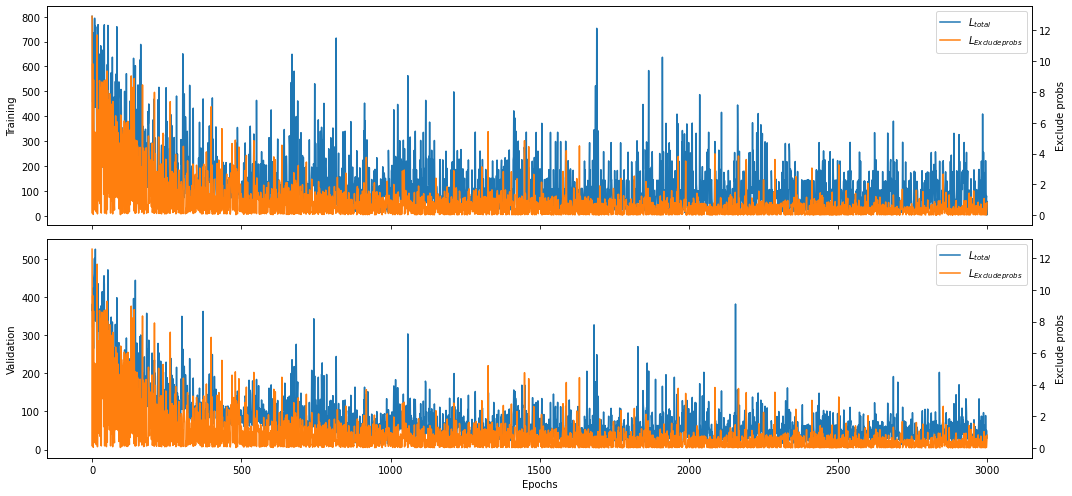

In [9]:
fig,ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
tax0 = ax[0].twinx()
tax0.plot([i.numpy()-j.numpy() for i,j in zip(logger['tr_loss'],logger['tr_probs'])],'tab:orange')
ax[0].plot([i.numpy() for i in logger['tr_loss']])
ax[0].legend(
    handles = [
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:blue',label = r'$L_{total}$'),
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:orange',label = r'$L_{Exclude probs}$')
    ]
)
ax[0].set_ylabel('Training')  
tax0.set_ylabel('Exclude probs')   
    
tax1 = ax[1].twinx()
tax1.plot([i.numpy()-j.numpy() for i,j in zip(logger['val_loss'],logger['val_probs'])],'tab:orange')
ax[1].plot([i.numpy() for i in logger['val_loss']])
ax[1].legend(
    handles = [
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:blue',label = r'$L_{total}$'),
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:orange',label = r'$L_{Exclude probs}$')
    ]
)
ax[1].set_ylabel('Validation')   
ax[1].set_xlabel('Epochs')   
tax1.set_ylabel('Exclude probs')   

fig.tight_layout()

# Visualization

In [10]:
test_y = labels_val.copy()
test_x = data_val.copy()
som_dim = model.som_dim

test_loader = tf.data.Dataset.from_tensor_slices(test_x).batch(1000)

outputs = []
outputs.append(model(y_data[:,:100]))

Output = [o['cluster_k'] for o in outputs]
Output_dist = [o['z_e_distance'] for o in outputs]

Output_recon_e = [o['x_reconstruction'] for o in outputs]
Output_recon_q = [o['q_reconstruction'] for o in outputs]

dist_all = tf.concat(Output_dist,0).numpy()

z_e (3000, 30)
z_q (3000, 30)


In [11]:
print("out",Output[0].shape)
k_all = tf.concat(Output,0).numpy()
print(k_all)


out (3000,)
[1133 1181 1130 ... 2440 1435 1425]


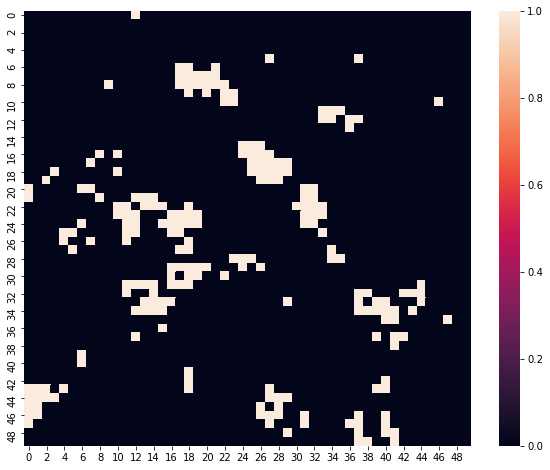

In [12]:
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
ones = np.ones(k_all.shape)

for i in range(som_dim[0]*som_dim[1]):
    
    si = np.where(k_all == i)
    if len(si[0]) > 0:
        clust_matr1[i] = len(si[0])
    
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
fig,ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(clust_matr1, vmin=0,vmax=1, ax = ax)
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



InvalidArgumentError: Matrix size-incompatible: In[0]: [784,1], In[1]: [30,256] [Op:MatMul]

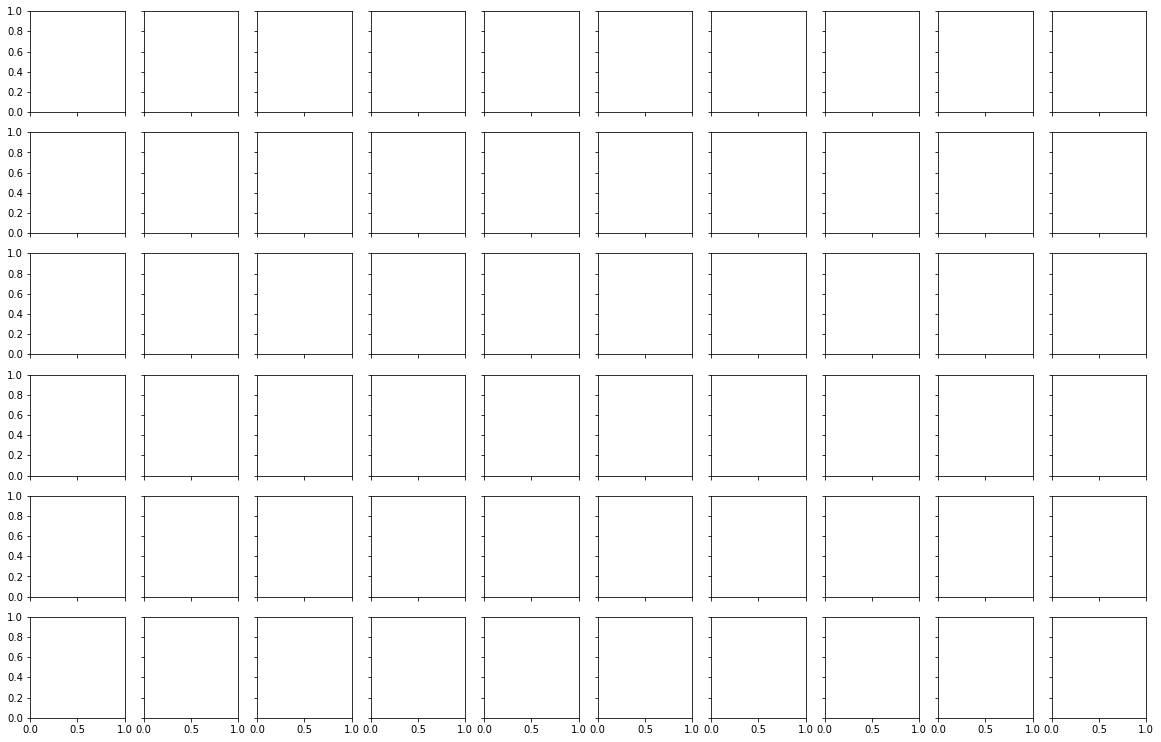

In [13]:
y_test = labels_val.copy()
x_test = data_val.copy()

fig,ax = plt.subplots(6,10,figsize=(20,13),sharex=True,sharey=True)

for number in range(10):
# number = 0
    test_idx = y_test == number
    spec_x_test = x_test[test_idx]
    spec_y_test = y_test[test_idx]
    
    sample_x_test = spec_x_test[np.random.randint(0,spec_x_test.shape[0])][np.newaxis, ...]
    output = model(sample_x_test)
    
    ax[0][number].imshow(output['inputs'][0, ...],cmap='Greys_r')
    ax[1][number].imshow(output['x_reconstruction'][0, ...],cmap='Greys_r')
    ax[2][number].imshow(output['q_reconstruction'][0, ...],cmap='Greys_r')
    
    
    sample_x_test = spec_x_test[np.random.randint(0,spec_x_test.shape[0])][np.newaxis, ...]
    output = model(sample_x_test)
    
    ax[3][number].imshow(output['inputs'][0, ...],cmap='Greys_r')
    ax[4][number].imshow(output['x_reconstruction'][0, ...],cmap='Greys_r')
    ax[5][number].imshow(output['q_reconstruction'][0, ...],cmap='Greys_r')
    
ax[0][0].set_ylabel('Real sample 1')
ax[1][0].set_ylabel('Recon sample 1')
ax[2][0].set_ylabel('Recon embed 1')

ax[3][0].set_ylabel('Real sample 2')
ax[4][0].set_ylabel('Recon sample 2')
ax[5][0].set_ylabel('Recon embed 2')

fig.tight_layout()